In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
import tensorflow as tf

In [2]:
c = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
n = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
p = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images'
l = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images'

In [3]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 5000) + os.listdir(p) + os.listdir(l)

In [4]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(3))
    elif category == 'Viral Pneumonia':
        categories.append(str(2))
    elif category == 'Lung_Opacity':
        categories.append(str(1))
    else:
        categories.append(str(0))

In [5]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    elif 'Lung_Opacity' in filenames[i]:
        filenames[i] = os.path.join(l, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,../input/covid19-radiography-database/COVID-19...,3
1,../input/covid19-radiography-database/COVID-19...,3
2,../input/covid19-radiography-database/COVID-19...,3
3,../input/covid19-radiography-database/COVID-19...,3
4,../input/covid19-radiography-database/COVID-19...,3


In [7]:
df.shape

(15973, 2)

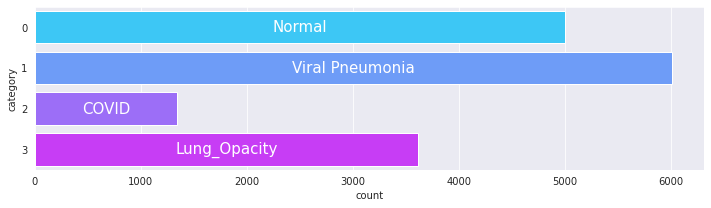

In [8]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity'], 
              label_type='center', size=15, color='w')
plt.show()

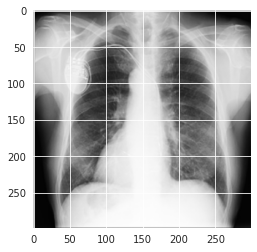

In [9]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

In [10]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [11]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [12]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [13]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=32
)

Found 12778 validated image filenames belonging to 4 classes.


In [14]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=32
)

Found 1598 validated image filenames belonging to 4 classes.


In [15]:
engine = tf.keras.applications.Xception(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 256x256x3
        input_shape = (256 , 256 , 3),

    )
    
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x =tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
out = tf.keras.layers.Dense(4, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model
model = tf.keras.models.Model(inputs = engine.input, outputs = out)
    # Compile the model

model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),
        #optimizer= SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        loss = 'categorical_crossentropy',
        # Set metrics to accuracy
        metrics = ['accuracy']
    )

2022-09-12 04:55:59.468370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 04:55:59.592991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 04:55:59.593825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 04:55:59.595184: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [18]:
 history = model.fit(train_generator,
                     validation_data=valid_generator, verbose=1, epochs=20,
                     callbacks=[early_stopping, reduce_lr , learning_rate_reduction])

2022-09-12 04:56:05.049976: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-12 04:56:10.796731: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


400/400 [==============================] - 339s 818ms/step - loss: 0.4278 - accuracy: 0.8459 - val_loss: 0.5268 - val_accuracy: 0.7622
Epoch 2/20
400/400 [==============================] - 277s 692ms/step - loss: 0.2423 - accuracy: 0.9154 - val_loss: 0.5555 - val_accuracy: 0.8217
Epoch 3/20
400/400 [==============================] - 278s 695ms/step - loss: 0.2015 - accuracy: 0.9271 - val_loss: 0.2134 - val_accuracy: 0.9249
Epoch 4/20
400/400 [==============================] - 278s 694ms/step - loss: 0.1821 - accuracy: 0.9369 - val_loss: 0.1795 - val_accuracy: 0.9312
Epoch 5/20
400/400 [==============================] - 282s 704ms/step - loss: 0.1696 - accuracy: 0.9404 - val_loss: 0.1873 - val_accuracy: 0.9287
Epoch 6/20
400/400 [==============================] - 277s 691ms/step - loss: 0.1555 - accuracy: 0.9457 - val_loss: 0.1615 - val_accuracy: 0.9456
Epoch 7/20
400/400 [==============================] - 277s 690ms/step - loss: 0.1399 - accuracy: 0.9512 - val_loss: 0.4869 - val_accura

In [19]:
model.save('Lung-Xception.h5')

In [20]:
test_set = valid_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(256,256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1597 validated image filenames belonging to 4 classes.


In [21]:
 model.evaluate(test_set)

50/50 [==============================] - 12s 242ms/step - loss: 0.2466 - accuracy: 0.9324


[0.24656543135643005, 0.9323732256889343]

In [22]:
prob = model.predict(test_set)
predIdxs = np.argmax(prob, axis=1) 


print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['Normal','Viral Pneumonia', 'COVID', 'Lung_Opacity'], digits=5))



                 precision    recall  f1-score   support

         Normal    0.93562   0.87200   0.90269       500
Viral Pneumonia    0.94924   0.93344   0.94128       601
          COVID    0.94406   1.00000   0.97122       135
   Lung_Opacity    0.89924   0.98892   0.94195       361

       accuracy                        0.93237      1597
      macro avg    0.93204   0.94859   0.93929      1597
   weighted avg    0.93324   0.93237   0.93188      1597



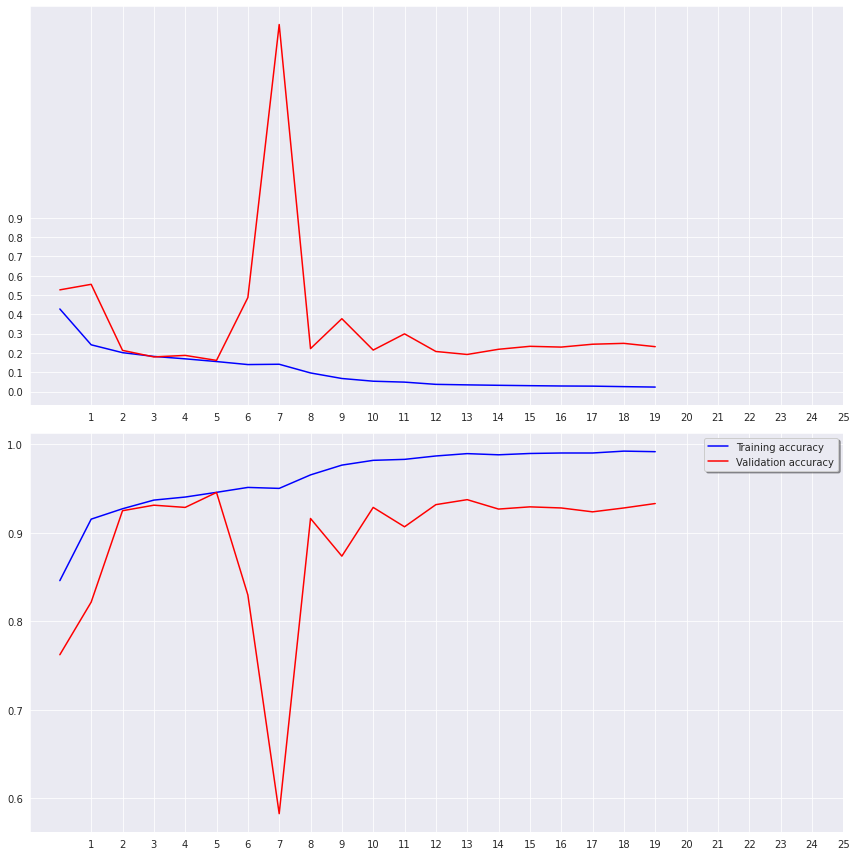

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 26, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 26, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

True value is : Normal
Prediction is:
Viral Pneumonia


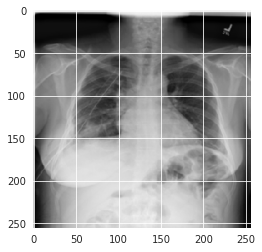

In [24]:
sample = random.choice(test_data['filename'])


category = sample.split('/')[-1].split('-')[0].upper()
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'VIRAL PNEUMONIA':
    true = 'Viral Pneumonia'
elif category == 'Lung_Opacity':
    true = 'Lung_Opacity'
else:
    true = 'Normal'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(256, 256))
img = img_to_array(image)/255
img = img.reshape((1, 256, 256, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
elif result == 2:
    print("Lung_Opacity")
else:
    print("COVID ")
    
plt.imshow(image)